In [ ]:
# uncomment and run this cell if you don't have the required libraries
# %pip install matplotlib calmap

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import calmap
from typing import List, Dict, Any
from datetime import datetime
import json

In [2]:
#load data
with open('data/meri-nova.json') as f:
    data = json.load(f)

In [3]:
def generate_heatmaps_for_years(
    response_data: List[Dict[str, Any]],
    years: List[int],
    name: str,
    figure_size: tuple = (20, 10),
    cmap: str = 'YlGn',
    fill_color: str = 'lightgray'
) -> None:
    """
    Generates GitHub-style activity heatmaps for specified years from JSON response data.

    Args:
        response_data: List of dictionaries containing activity data with 'createdAt' timestamps
        years: List of years to generate heatmaps for
        name: Name to display in the plot title
        figure_size: Tuple specifying matplotlib figure size
        cmap: Matplotlib colormap name
        fill_color: Color for days with no activity

    Raises:
        ValueError: If input data validation fails

    Example:
        >>> data = [{'createdAt': '2024-01-01T12:34:56Z'}, ...]
        >>> generate_heatmaps_for_years(data, [2024], "John Doe")
    """
    # Validate input parameters
    if not response_data:
        raise ValueError("Input response_data cannot be empty")
    if not years:
        raise ValueError("Years list cannot be empty")
    if any(year < 1970 or year > 2100 for year in years):
        raise ValueError("Invalid year value in years list")

    df = _prepare_dataframe(response_data)
    
    for year in sorted(set(years)):  # Process unique years in sorted order
        try:
            activity_series = _process_year_data(df, year)
            _plot_year_heatmap(activity_series, year, name, figure_size, cmap, fill_color)
        except ValueError as e:
            print(f"Skipping year {year} due to error: {str(e)}")
            continue

def _prepare_dataframe(raw_data: List[Dict[str, Any]]) -> pd.DataFrame:
    """Convert and prepare raw data into standardized DataFrame format."""
    df = pd.DataFrame(raw_data)
    
    if 'createdAt' not in df.columns:
        raise ValueError("Input data must contain 'createdAt' field")

    # Convert to datetime and handle timezones
    df['createdAt'] = pd.to_datetime(df['createdAt']).dt.tz_localize(None)
    return df.sort_values(by='createdAt').reset_index(drop=True)


def _process_year_data(df: pd.DataFrame, year: int) -> pd.Series:
    """Process data for a single year and return activity time series."""
    year_start = datetime(year, 1, 1)
    year_end = datetime(year, 12, 31)
    
    # Filter and validate year data
    year_mask = (df['createdAt'] >= year_start) & (df['createdAt'] <= year_end)
    year_df = df.loc[year_mask]
    
    if year_df.empty:
        raise ValueError(f"No data available for year {year}")
    
    # Aggregate daily activity
    daily_activity = year_df.groupby(year_df['createdAt'].dt.date).size()
    daily_activity.index = pd.to_datetime(daily_activity.index)
    
    # Create complete date range for the year
    date_range = pd.date_range(start=year_start, end=year_end, freq='D')
    return daily_activity.reindex(date_range, fill_value=0)

def _plot_year_heatmap(
    activity: pd.Series,
    year: int,
    name: str,
    figure_size: tuple,
    cmap: str,
    fill_color: str
) -> None:
    """Generate and display the heatmap visualization for a single year."""
    plt.figure(figsize=figure_size)
    calmap.yearplot(
        activity,
        year=year,
        cmap=cmap,
        fillcolor=fill_color,
        linewidth=0.5
    )
    plt.title(
        f"{name}'s LinkedIn Activity Heatmap - {year}",
        fontsize=16,
        pad=20
    )
    plt.tight_layout()
    plt.show()

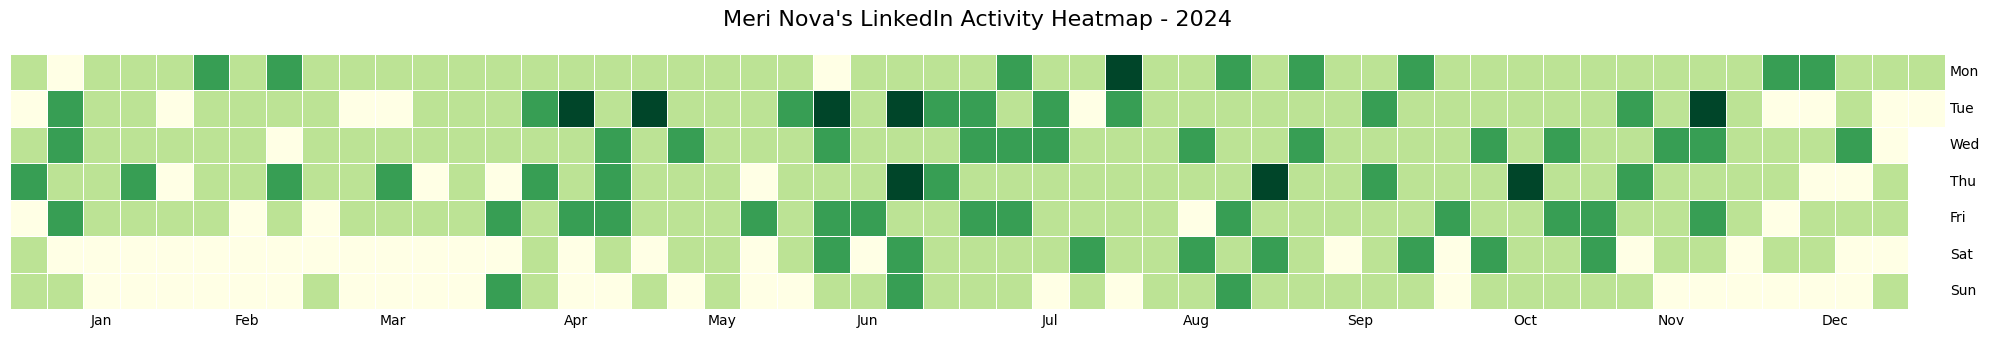

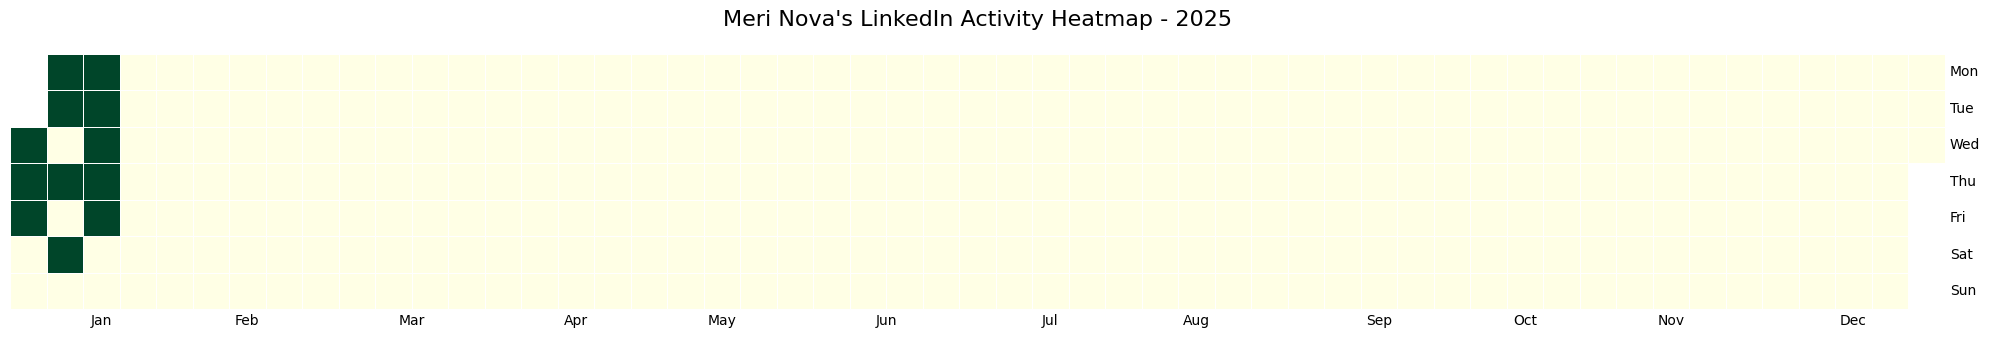

In [6]:
generate_heatmaps_for_years(data, [2024,2025], "Meri Nova")

# Interactive Version

In [6]:
from datetime import datetime
from typing import List, Dict, Any
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from dateutil.relativedelta import relativedelta

def generate_plotly_heatmaps_for_years(
    response_data: List[Dict[str, Any]],
    years: List[int],
    name: str,
    colorscale: str = 'YlGn',
) -> None:
    """
    Generates interactive Plotly calendar heatmaps for specified years.

    Args:
        response_data: List of dictionaries containing 'createdAt' timestamps
        years: List of years to generate heatmaps for
        name: Name to display in plot titles
        colorscale: Plotly color scale name

    Example:
        >>> data = [{'createdAt': '2024-01-01T12:34:56Z'}, ...]
        >>> generate_plotly_heatmaps_for_years(data, [2024], "John Doe")
    """
    df = _prepare_dataframe(response_data)
    
    for year in sorted(set(years)):
        try:
            activity_data, all_dates = _process_year_data(df, year)
            _create_plotly_heatmap(activity_data, all_dates, year, name, colorscale)
        except ValueError as e:
            print(f"Skipping year {year}: {str(e)}")


def _process_year_data(df: pd.DataFrame, year: int) -> tuple:
    """Process data for a single year and return matrix with dates."""
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)
    
    # Create complete date range for the year
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Filter and aggregate data
    mask = (df['createdAt'] >= start_date) & (df['createdAt'] <= end_date)
    activity = df.loc[mask].groupby(df['createdAt'].dt.date).size()
    activity = activity.reindex(date_range.date, fill_value=0)
    
    return activity, date_range

def _create_plotly_heatmap(
    activity: pd.Series,
    all_dates: pd.DatetimeIndex,
    year: int,
    name: str,
    colorscale: str
) -> None:
    """Generate interactive Plotly calendar heatmap."""
    # Create matrix for calendar layout
    first_date = all_dates[0]
    last_date = all_dates[-1]
    
    # Calculate week numbers and day of week
    dates = [d.date() for d in all_dates]
    week_numbers = [d.isocalendar().week for d in dates]
    day_of_week = [d.isocalendar().weekday for d in dates]
    
    # Adjust for ISO week year boundary dates
    if dates[0].isocalendar().year != year:
        week_numbers = [0 if wn >= 52 else wn for wn in week_numbers]
    if dates[-1].isocalendar().year != year:
        week_numbers = [wn if d.isocalendar().year == year else 53 
                       for wn, d in zip(week_numbers, dates)]
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'date': dates,
        'week': week_numbers,
        'day': day_of_week,
        'count': activity.values,
        'text': [f"Date: {d.strftime('%Y-%m-%d')}<br>Count: {c}" 
                for d, c in zip(dates, activity.values)]
    })
    
    # Pivot to matrix format
    matrix = plot_df.pivot_table(
        index='day', 
        columns='week', 
        values='count', 
        aggfunc='sum',
        fill_value=0
    )
    annotations = plot_df.pivot_table(
        index='day', 
        columns='week', 
        values='text', 
        aggfunc='first',
        fill_value=''
    )
    
    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=matrix.values,
        x=matrix.columns,
        y=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
        text=annotations.values,
        hoverinfo='text',
        colorscale=colorscale,
        showscale=True,
        xgap=3,
        ygap=3,
    ))
    
    # Customize layout
    fig.update_layout(
        title=f"{name}'s Activity Heatmap - {year}",
        height=200,
        margin=dict(t=40, b=20, l=20, r=20),
        yaxis=dict(autorange='reversed', showgrid=False),
        xaxis=dict(showgrid=False),
        plot_bgcolor='white'
    )
    
    # Add month separators
    current_month = first_date.month
    months = []
    for d in pd.date_range(first_date, last_date, freq='MS'):
        if d.month != current_month:
            week_num = d.isocalendar().week
            months.append(dict(
                type='line',
                x0=week_num - 1.5,
                x1=week_num - 1.5,
                y0=-0.5,
                y1=6.5,
                line=dict(color='rgba(0,0,0,0.2)', width=1)
            ))
            current_month = d.month
    
    fig.update_layout(shapes=months)
    fig.show()

In [7]:
generate_plotly_heatmaps_for_years(
    response_data=data,
    years=[2024, 2025],
    name="Meri Nova",
    colorscale='YlGn'  # Try different colorscales: 'Viridis', 'Plasma', etc.
)